In [4]:
library(qvalue)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [1]:
### 20 MOFA as background, 10 MOFA tested
## DA eQTL only (D30+D52+D52ROT)

In [7]:
mydir = "/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/May2021/"
file = paste0(mydir,"MOFA/MOFA10/summary.csv")
df = read.csv(file, row.names=1)
head(df)

,gene,n_snps,chrom,pv_raw,snpID,pv,gene_old
0,LINC00662,1,19,0.058274791,19_28250771_G_A,0.058274791,LINC00662
1,ATRAID,2,2,0.663537037,2_27389195_A_G,1.000000000,ATRAID
2,ATRAID,2,2,0.815934343,2_27527246_T_A,1.000000000,ATRAID
3,CNDP2,1,18,0.107678834,18_72159310_T_A,0.107678834,CNDP2
4,GPR22,1,7,0.005806852,7_106914944_T_C,0.005806852,GPR22
5,MGST3,1,1,0.006567903,1_165599649_C_T,0.006567903,MGST3


In [8]:
df = df[order(df$pv, df$pv_raw),]
df = df[-which(duplicated(df$gene)),]
df$qv = qvalue(df$pv)$qvalue

In [9]:
df2 = df[df$qv < 0.05,]
nrow(df2)

[1] 213

In [10]:
df2$eqtl = paste0(df2$gene,"-",df2$snpID)
head(df2,2)

,gene,n_snps,chrom,pv_raw,snpID,pv,gene_old,qv,eqtl
1387,PRPH2,2,6,9.329769e-43,6_42672574_G_A,1.865954e-42,PRPH2,2.563820e-39,PRPH2-6_42672574_G_A
303,CD36,1,7,4.839668e-42,7_80240689_T_C,4.839668e-42,CD36,3.324852e-39,CD36-7_80240689_T_C


In [11]:
### betaGxC estimate of magnitude
df_beta = read.csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/May2021/genetic_effect/MOFA10/eqtl_est_single_GxE_genetic_effects.csv", row.names=1)
colnames(df_beta)[1] = "beta_GxC"
df_beta$eqtl = gsub("_-","-",df_beta$eqtl)
nrow(df_beta)
head(df_beta,2)

[1] 213

,beta_GxC,eqtl
0,0.7559366,ABHD10-3_111697439_T_G
1,0.3794608,ABHD12B-14_51328222_C_T


In [12]:
### betaG's across cells from model 
df_betaG = read.csv("/hps/nobackup/stegle/users/acuomo/all_scripts/struct_LMM2/sc_neuroseq/May2021/genetic_effect/MOFA10/eqtl_persistent_genetic_effect_all.txt", sep="\t",row.names = 1)
df_betaG$eqtl = rownames(df_betaG)
nrow(df_betaG)
head(df_betaG,2)

[1] 213

,beta_G,eqtl
ABHD10-3_111697439_T_G,0.3034083,ABHD10-3_111697439_T_G
ABHD12B-14_51328222_C_T,-0.1078338,ABHD12B-14_51328222_C_T


In [13]:
df_betas = inner_join(df_beta, df_betaG)
nrow(df_betas)
head(df_betas,2)

Joining, by = "eqtl"


[1] 213

beta_GxC,eqtl,beta_G
0.7559366,ABHD10-3_111697439_T_G,0.3034083
0.3794608,ABHD12B-14_51328222_C_T,-0.1078338


In [14]:
df3 = inner_join(df2, df_betas)
nrow(df3)
head(df3,2)

Joining, by = "eqtl"


[1] 212

gene,n_snps,chrom,pv_raw,snpID,pv,gene_old,qv,eqtl,beta_GxC,beta_G
PRPH2,2,6,9.329769e-43,6_42672574_G_A,1.865954e-42,PRPH2,2.563820e-39,PRPH2-6_42672574_G_A,0.9545840,0.3375220
CD36,1,7,4.839668e-42,7_80240689_T_C,4.839668e-42,CD36,3.324852e-39,CD36-7_80240689_T_C,0.8591097,0.2302262


In [15]:
df3$gene_name = df3$gene
df3$snp_id = df3$snpID
head(df3,2)

gene,n_snps,chrom,pv_raw,snpID,pv,gene_old,qv,eqtl,beta_GxC,beta_G,gene_name,snp_id
PRPH2,2,6,9.329769e-43,6_42672574_G_A,1.865954e-42,PRPH2,2.563820e-39,PRPH2-6_42672574_G_A,0.9545840,0.3375220,PRPH2,6_42672574_G_A
CD36,1,7,4.839668e-42,7_80240689_T_C,4.839668e-42,CD36,3.324852e-39,CD36-7_80240689_T_C,0.8591097,0.2302262,CD36,7_80240689_T_C


In [19]:
#load map HGNC to ensembl
mapping_df = read.csv('/nfs/leia/research/stegle/dseaton/genomes/hg19/annotation/geneid_mappings/hgnc_symbol2ensembl_gene_id.txt', sep='\t')
colnames(mapping_df)[1] = "gene_name"
head(mapping_df,2)

gene_name,ensembl_gene_id
SLC25A26,ENSG00000261657
,ENSG00000223116


In [24]:
df4 = df3[,c("gene_name","snp_id","pv_raw","pv","qv","beta_G","beta_GxC")]
df4 = left_join(df4, mapping_df)

Joining, by = "gene_name"


In [25]:
nrow(df4)
df4 = df4[-which(duplicated(df4$gene)),]
nrow(df4)
head(df4,2)

[1] 221

[1] 212

gene_name,snp_id,pv_raw,pv,qv,beta_G,beta_GxC,ensembl_gene_id
PRPH2,6_42672574_G_A,9.329769e-43,1.865954e-42,2.563820e-39,0.3375220,0.9545840,ENSG00000112619
CD36,7_80240689_T_C,4.839668e-42,4.839668e-42,3.324852e-39,0.2302262,0.8591097,ENSG00000135218


In [26]:
length(unique(df4$gene_name))

[1] 212

In [27]:
write.csv(df4, "/hps/nobackup/stegle/users/acuomo/singlecell_interaction_eqtls/neuroseq_GxC_SuppTable2.csv")

In [1]:
########################################################################################################
########################################################################################################
########################################################################################################
########################################################################################################

In [2]:
library(ggplot2)

In [3]:
df = read.csv("/hps/nobackup/stegle/users/acuomo/singlecell_interaction_eqtls/neuroseq_GxC_SuppTable2.csv", row.names = 1)
head(df)

gene_name,snp_id,pv_raw,pv,qv,beta_G,beta_GxC,ensembl_gene_id
PRPH2,6_42672574_G_A,9.329769e-43,1.865954e-42,2.563820e-39,0.3375220,0.9545840,ENSG00000112619
CD36,7_80240689_T_C,4.839668e-42,4.839668e-42,3.324852e-39,0.2302262,0.8591097,ENSG00000135218
RPS26,12_56401085_G_A,9.758139e-39,9.758139e-39,4.469228e-36,-0.9015587,0.9185762,ENSG00000197728
CRYBB2,22_25845855_C_G,3.215298e-35,3.215298e-35,1.104455e-32,0.7428577,1.7763448,ENSG00000244752
HLA.DRB5,6_32551716_C_G,5.604129e-35,1.120826e-34,3.080029e-32,-0.5408206,2.3994028,NA
GPR171,3_150847047_A_G,3.399394e-34,3.399394e-34,7.784612e-32,0.5102445,0.9916148,ENSG00000174946


[1] 0.5062096

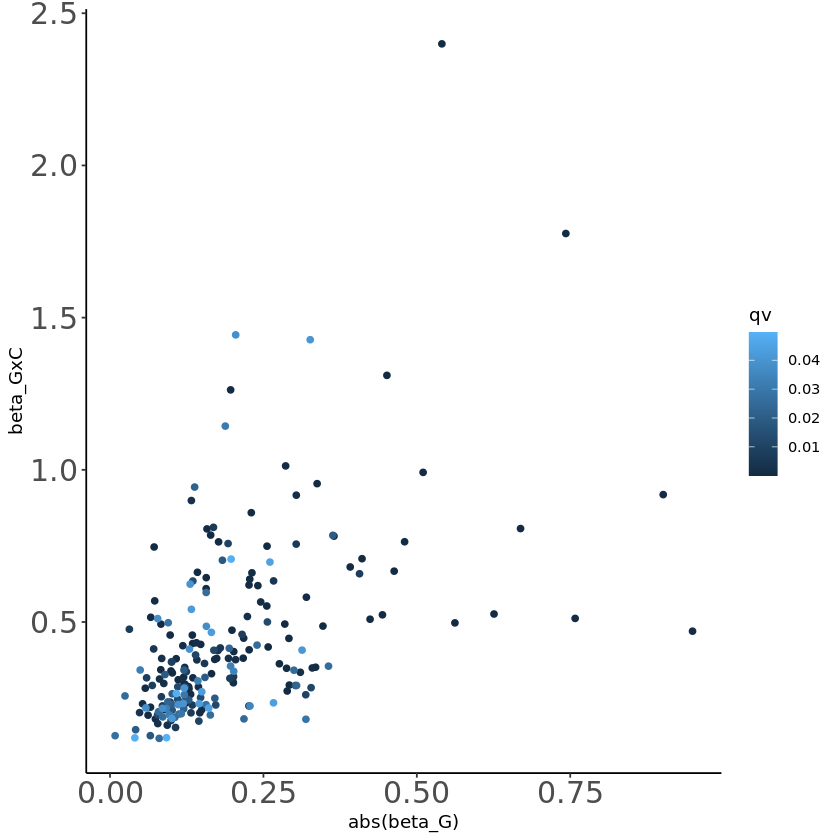

In [5]:
cor(abs(df$beta_G), df$beta_GxC)
p = ggplot(df, aes(x=abs(beta_G), y=beta_GxC, colour=qv)) + geom_point() + theme_classic() 
p = p + theme(axis.text.x = element_text(size = 18), axis.text.y = element_text(size = 18))
# p = p + scale_color_gradient2(low = "white",mid = "coral",high = "firebrick", midpoint = 15)
# p = p + sc
p